In [49]:
import pandas as pd
import numpy as np

df = pd.read_csv("Arrival data.csv")

In [50]:
df = df.iloc[:,:4]
df

,Week,Day,Arrival,Adjusted Arrival
0,1,Weekday,08:01:26,00:01:26
1,1,Weekday,08:06:59,00:06:59
2,1,Weekday,08:11:07,00:11:07
3,1,Weekday,08:13:08,00:13:08
4,1,Weekday,08:13:56,00:13:56
...,...,...,...,...
42066,8,Sun,00:52:20,16:52:20
42067,8,Sun,00:53:12,16:53:12
42068,8,Sun,00:55:38,16:55:38
42069,8,Sun,00:58:41,16:58:41


In [51]:
weekday = df[df['Day']=='Weekday']
saturday = df[df['Day']=='Sat']
sunday = df[df['Day']=='Sun']

In [52]:
def DataManip(data):
    data['Arrival'] = pd.to_timedelta(data['Arrival'].astype(str))

    # Subtract 8 hours from each time to adjust the range from 0 to 17 hours
    data['Adjusted Arrival'] = data['Arrival'] - pd.Timedelta(hours=8)
    data['Adjusted Arrival'] = data['Adjusted Arrival'].apply(
        lambda x: x + pd.Timedelta(days=1) if x.total_seconds() < 0 else x)
    
    data = data.rename(columns={"Week ": "Day_Number", "Day": "Day_Type"})
    return data

# Function to calculate interarrival times
def calculate_interarrival(group):
    # Shift the 'Adjusted Arrival' column to get the difference with the previous row
    interarrival = group['Adjusted Arrival'].diff()

    # For the first row of each group, use the 'Adjusted Arrival' time itself
    interarrival.iloc[0] = group['Adjusted Arrival'].iloc[0]

    # Convert interarrival times to seconds
    return interarrival.dt.total_seconds()

weekday = DataManip(weekday)
weekday['Interarrival Time (sec)'] = weekday.groupby('Day_Number').apply(calculate_interarrival).reset_index(level=0, drop=True)

saturday = DataManip(saturday)
saturday['Interarrival Time (sec)'] = saturday.groupby('Day_Number').apply(calculate_interarrival).reset_index(level=0, drop=True)

sunday = DataManip(sunday)
sunday['Interarrival Time (sec)'] = sunday.groupby('Day_Number').apply(calculate_interarrival).reset_index(level=0, drop=True)


C:\Users\ramon\AppData\Local\Temp\ipykernel_20260\3593575078.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Arrival'] = pd.to_timedelta(data['Arrival'].astype(str))
C:\Users\ramon\AppData\Local\Temp\ipykernel_20260\3593575078.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Adjusted Arrival'] = data['Arrival'] - pd.Timedelta(hours=8)
C:\Users\ramon\AppData\Local\Temp\ipykernel_20260\3593575078.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFram

In [53]:
weekday.columns

Index(['Day_Number', 'Day_Type', 'Arrival', 'Adjusted Arrival',
       'Interarrival Time (sec)'],
      dtype='object')

In [54]:
def calculate_lambda_per_hour(data):
    # Convert 'Arrival' to timedelta
    data['Arrival'] = pd.to_timedelta(data['Arrival'])

    # Extract hour from 'Arrival'
    data['Hour'] = data['Arrival'].dt.components.hours

    # Initialize a dictionary to store lambda values for each hour
    lambda_per_hour = {hour: [] for hour in range(8, 18)}

    # Iterate over each day
    for day in range(1, 11):
        day_data = data[data['Day_Number'] == day]
        
        # Calculate lambda for each hour
        for hour in range(8, 18):
            hour_data = day_data[day_data['Hour'] == hour]
            if not hour_data.empty:
                mean_interarrival = hour_data['Interarrival Time (sec)'].mean()
                lambda_hour_day = 1 / mean_interarrival if mean_interarrival > 0 else 0
                lambda_per_hour[hour].append(lambda_hour_day)

    # Average the lambda values over days
    average_lambda_per_hour = {hour: sum(lambdas) / len(lambdas) if lambdas else 0 
                               for hour, lambdas in lambda_per_hour.items()}

    return average_lambda_per_hour



In [56]:
weekday

,Day_Number,Day_Type,Arrival,Adjusted Arrival,Interarrival Time (sec),Hour
0,1,Weekday,0 days 08:01:26,0 days 00:01:26,86.0,8
1,1,Weekday,0 days 08:06:59,0 days 00:06:59,333.0,8
2,1,Weekday,0 days 08:11:07,0 days 00:11:07,248.0,8
3,1,Weekday,0 days 08:13:08,0 days 00:13:08,121.0,8
4,1,Weekday,0 days 08:13:56,0 days 00:13:56,48.0,8
...,...,...,...,...,...,...
13715,10,Weekday,0 days 00:48:05,0 days 16:48:05,144.0,0
13716,10,Weekday,0 days 00:51:35,0 days 16:51:35,210.0,0
13717,10,Weekday,0 days 00:52:53,0 days 16:52:53,78.0,0
13718,10,Weekday,0 days 00:54:56,0 days 16:54:56,123.0,0


In [55]:
lambdas_weekday = calculate_lambda_per_hour(weekday)
lambdas_saturday = calculate_lambda_per_hour(saturday)
lambdas_sunday = calculate_lambda_per_hour(sunday)

print(lambdas_weekday)
print(lambdas_saturday)
print(lambdas_sunday)

{8: 0.006893761926018875, 9: 0.012475392904267829, 10: 0.017483052538707602, 11: 0.02139584250190731, 12: 0.02943555039126114, 13: 0.02999634517260711, 14: 0.028011004604845086, 15: 0.026881650906669597, 16: 0.029086088546490297, 17: 0.031559196477356305}
{8: 0.009073448653184569, 9: 0.013332051244036866, 10: 0.018030942473728273, 11: 0.022450113712513903, 12: 0.028518824481934386, 13: 0.03054366236121297, 14: 0.03321669508153579, 15: 0.03141825380800484, 16: 0.03567176718590945, 17: 0.04806053981985729}
{8: 0.008062202623267295, 9: 0.011498744409606059, 10: 0.01885210013477121, 11: 0.02224008366798762, 12: 0.02900605987146785, 13: 0.03100517012033791, 14: 0.03506600587672508, 15: 0.03341876207021456, 16: 0.039615478871957294, 17: 0.05066770652409214}


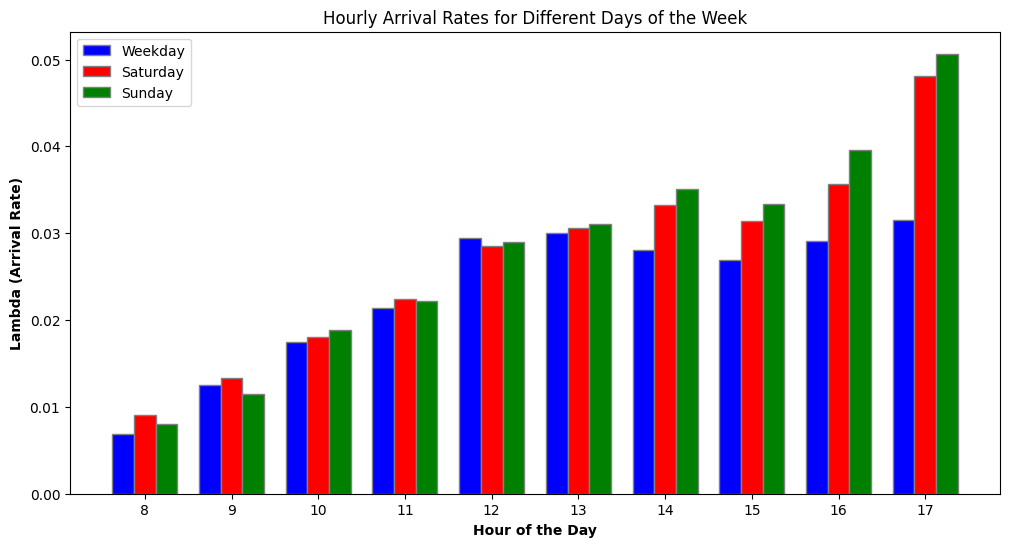

In [62]:
import matplotlib.pyplot as plt

# Your data
weekday_data = {8: 0.006893761926018875, 9: 0.012475392904267829, 10: 0.017483052538707602, 11: 0.02139584250190731, 12: 0.02943555039126114, 13: 0.02999634517260711, 14: 0.028011004604845086, 15: 0.026881650906669597, 16: 0.029086088546490297, 17: 0.031559196477356305}
saturday_data = {8: 0.009073448653184569, 9: 0.013332051244036866, 10: 0.018030942473728273, 11: 0.022450113712513903, 12: 0.028518824481934386, 13: 0.03054366236121297, 14: 0.03321669508153579, 15: 0.03141825380800484, 16: 0.03567176718590945, 17: 0.04806053981985729}
sunday_data = {8: 0.008062202623267295, 9: 0.011498744409606059, 10: 0.01885210013477121, 11: 0.02224008366798762, 12: 0.02900605987146785, 13: 0.03100517012033791, 14: 0.03506600587672508, 15: 0.03341876207021456, 16: 0.039615478871957294, 17: 0.05066770652409214}

# Convert the dictionaries to DataFrames
df_weekday = pd.DataFrame(list(weekday_data.items()), columns=['Hour', 'Lambda'])
df_saturday = pd.DataFrame(list(saturday_data.items()), columns=['Hour', 'Lambda'])
df_sunday = pd.DataFrame(list(sunday_data.items()), columns=['Hour', 'Lambda'])

# Ensure hours are aligned
hours = sorted(set(df_weekday['Hour']) | set(df_saturday['Hour']) | set(df_sunday['Hour']))
df_weekday = df_weekday.set_index('Hour').reindex(hours).reset_index()
df_saturday = df_saturday.set_index('Hour').reindex(hours).reset_index()
df_sunday = df_sunday.set_index('Hour').reindex(hours).reset_index()

# Setting up the bar width
bar_width = 0.25

# Setting the position of the bars
r1 = np.arange(len(hours))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

# Creating the bar chart
plt.figure(figsize=(12, 6))
plt.bar(r1, df_weekday['Lambda'], color='b', width=bar_width, edgecolor='grey', label='Weekday')
plt.bar(r2, df_saturday['Lambda'], color='r', width=bar_width, edgecolor='grey', label='Saturday')
plt.bar(r3, df_sunday['Lambda'], color='g', width=bar_width, edgecolor='grey', label='Sunday')

# Adding labels and title
plt.xlabel('Hour of the Day', fontweight='bold')
plt.ylabel('Lambda (Arrival Rate)', fontweight='bold')
plt.xticks([r + bar_width for r in range(len(hours))], hours)
plt.title('Hourly Arrival Rates for Different Days of the Week')

# Creating a legend
plt.legend()

# Show the plot
plt.show()

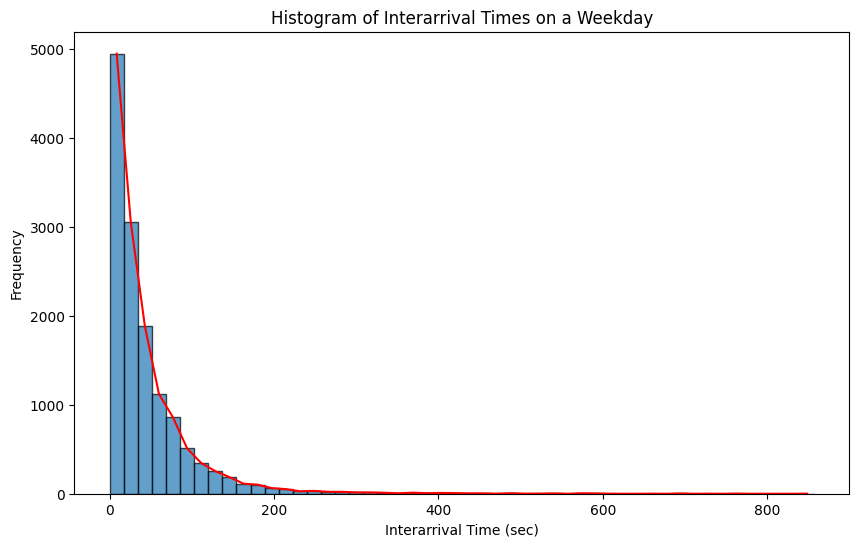

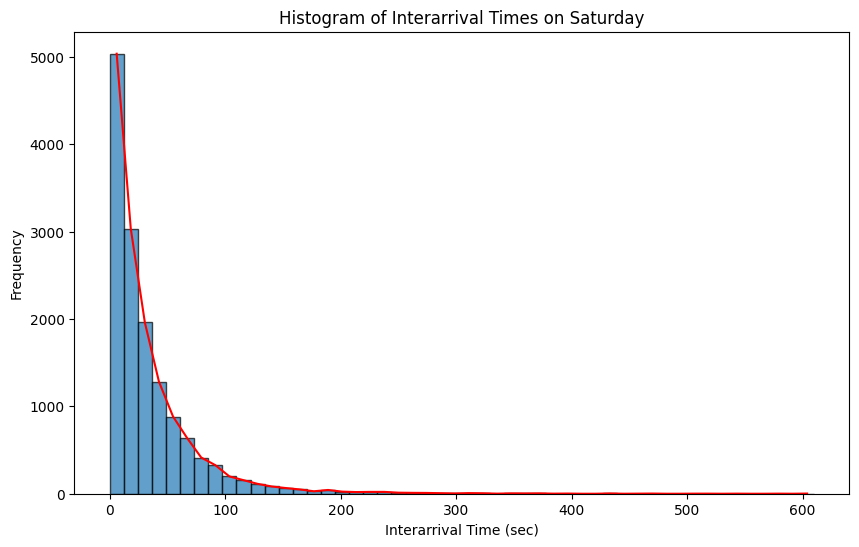

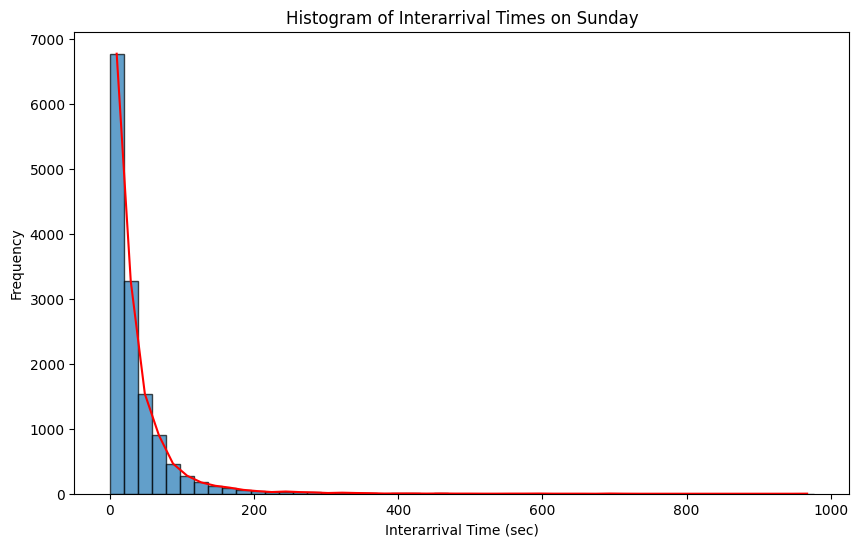

In [66]:
import matplotlib.pyplot as plt
# Creating the histogram
def hist_maker(df, day):
    plt.figure(figsize=(10, 6))
    
    # Calculate histogram data
    counts, bin_edges = np.histogram(df['Interarrival Time (sec)'], bins=50)
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])  # Calculate bin centers

    # Plot histogram
    plt.hist(df['Interarrival Time (sec)'], bins=50, edgecolor='black', alpha=0.7)

    # Plot line through the top of each bar
    plt.plot(bin_centers, counts, color='red', linestyle='-')  # Removed marker

    # Adding titles and labels
    plt.title(f'Histogram of Interarrival Times on {day}')
    plt.xlabel('Interarrival Time (sec)')
    plt.ylabel('Frequency')
    
    plt.show()

hist_maker(weekday, "a Weekday")
hist_maker(saturday, "Saturday")
hist_maker(sunday, "Sunday")
